# Random Forest with C2RCC and OSPAR Habitats 2022 dataset - Test

## Setup

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
import json

In [3]:
import geopandas as gpd
from shapely.geometry import Point

In [4]:
from shapely.geometry import Polygon, MultiPolygon

In [5]:
import rioxarray

In [6]:
import rasterio
from rasterio.crs import CRS

In [7]:
from rasterio.features import rasterize

In [135]:
from rasterio.transform import from_bounds, from_origin

In [162]:
from rasterio.warp import calculate_default_transform, reproject

In [163]:
from rasterio.enums import Resampling

In [9]:
from pyproj import Transformer

In [10]:
import matplotlib.pyplot as plt

In [11]:
from scipy.spatial import cKDTree

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [13]:
from scipy import stats

In [14]:
result_dir = "result-{tileId}"

In [109]:
substrate_dir = "substrate_rasters"

Specific files for this test

In [16]:
test_dir = result_dir.format(tileId='30UUA')

In [17]:
c2rcc_fp = os.path.join(test_dir, os.listdir(test_dir)[0])

In [18]:
with open('AOI_Lookup.txt', 'r') as fp:
    aoi_lookup = json.load(fp)

In [19]:
poly_id = aoi_lookup['30UUA'][os.listdir(test_dir)[0]]

In [110]:
substrate_fp = os.path.join(substrate_dir, f"{poly_id}.tif")

## C2RCC

In [21]:
c2rcc_ds = xr.open_dataset(c2rcc_fp)

In [22]:
c2rcc_ds

<xarray.Dataset> Size: 2GB
Dimensions:            (y: 3473, x: 3357, tp_y: 5, tp_x: 5)
Coordinates:
    lat                (y, x) float64 93MB ...
    lon                (y, x) float64 93MB ...
Dimensions without coordinates: y, x, tp_y, tp_x
Data variables: (12/70)
    metadata           int8 1B ...
    rrs_B1             (y, x) float32 47MB ...
    rrs_B2             (y, x) float32 47MB ...
    rrs_B3             (y, x) float32 47MB ...
    rrs_B4             (y, x) float32 47MB ...
    rrs_B5             (y, x) float32 47MB ...
    ...                 ...
    Rhow_OOS_mask      int8 1B ...
    Kd489_OOR_mask     int8 1B ...
    Kdmin_OOR_mask     int8 1B ...
    Kd489_at_max_mask  int8 1B ...
    Kdmin_at_max_mask  int8 1B ...
    Valid_PE_mask      int8 1B ...
Attributes:
    Conventions:       CF-1.4
    TileSize:          610:610
    product_type:      C2RCC_S2-MSI
    metadata_profile:  beam
    metadata_version:  0.5
    auto_grouping:     iop:conc:rrs:rhown:kd:unc
    start_date:        23-JUN-2020 11:21:19.024000
    stop_date:         23-JUN-2020 11:21:19.024000

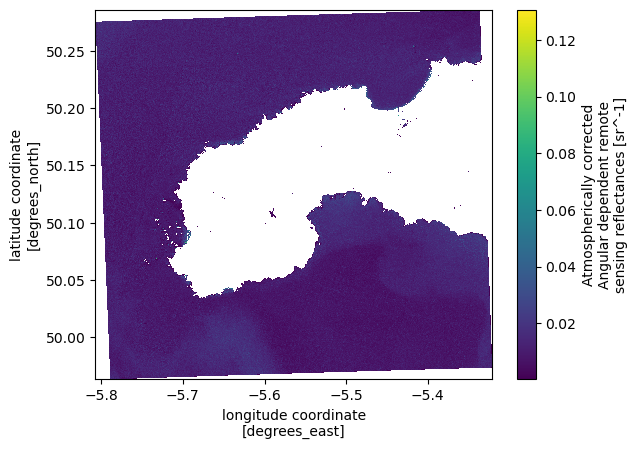

In [23]:
c2rcc_ds.rrs_B2.where(c2rcc_ds.rrs_B2 > 0).plot(x="lon", y="lat")

## OSPAR habitat data

### Prepare dataframe

In [24]:
habitats = pd.read_csv('OSPAR2022Points.csv')

In [25]:
habitats.head()

,Join_Count,HabType,HabSubType,HabStatus,Latitude,Longitude,Energy,Biozone,Substrate,All2019DL2
0,1,Zostera beds,Unknown,Present,55.045203,-7.125105,Low energy,Infralittoral,Seabed,Infralittoral seabed
1,0,Zostera beds,Zostera noltii beds,Present,52.669012,-9.569316,NaN,NaN,NaN,NaN
2,0,Zostera beds,Zostera noltii beds,Present,52.305249,-9.854169,NaN,NaN,NaN,NaN
3,1,Zostera beds,Zostera noltii beds,Present,52.142788,-9.943158,No energy information,Infralittoral,Seabed,Infralittoral seabed
4,1,Zostera beds,Zostera marina beds,Present,52.264474,-9.825030,High energy,Infralittoral,Seabed,Infralittoral seabed


In [26]:
habitats.drop(columns=['Energy', 'Biozone', 'All2019DL2', 'Join_Count', 'HabSubType'], inplace=True)

In [27]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate
0,Zostera beds,Present,55.045203,-7.125105,Seabed
1,Zostera beds,Present,52.669012,-9.569316,NaN
2,Zostera beds,Present,52.305249,-9.854169,NaN
3,Zostera beds,Present,52.142788,-9.943158,Seabed
4,Zostera beds,Present,52.264474,-9.825030,Seabed


In [28]:
habitats['Substrate'] = habitats['Substrate'].fillna('Seabed')

In [29]:
habitats['HabType'].unique()

array(['Zostera beds', 'Intertidal mudflats', 'Maerl beds',
       'Ostrea edulis beds',
       'Sea-pen and burrowing megafauna communities',
       'Deep-sea sponge aggregations', 'Carbonate mounds',
       'Lophelia pertusa reefs', 'Coral gardens', 'Kelp forests',
       'Modiolus modiolus horse mussel beds',
       'Intertidal Mytilus edulis beds on mixed and sandy sediments',
       'Seamounts', 'Oceanic ridges with hydrothermal vents/fields',
       'Sabellaria spinulosa reefs', 'Littoral chalk communities'],
      dtype=object)

In [30]:
habtypes = ['Zostera beds', 'Kelp forests']

In [31]:
habitats['HabType'] = habitats['HabType'].apply(lambda x: x if x in habtypes else 'Other')

In [32]:
habitats['HabType'].unique()

array(['Zostera beds', 'Other', 'Kelp forests'], dtype=object)

## Extract pixel values

In [33]:
latitudes = c2rcc_ds['lat'].values.ravel()
longitudes = c2rcc_ds['lon'].values.ravel()

In [34]:
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()

In [35]:
habitats = habitats[
    (habitats['Latitude'] >= lat_min) & (habitats['Latitude'] <= lat_max) &
    (habitats['Longitude'] >= lon_min) & (habitats['Longitude'] <= lon_max)
].reset_index(drop=True)

In [36]:
coords_tree = cKDTree(np.column_stack((latitudes, longitudes)))

In [37]:
distances, nearest_indices = coords_tree.query(np.column_stack((habitats['Latitude'], habitats['Longitude'])))

In [38]:
ny, nx = c2rcc_ds.sizes['y'], c2rcc_ds.sizes['x']

In [39]:
y_indices, x_indices = np.unravel_index(nearest_indices, (ny, nx))

In [40]:
habitats['x'] = x_indices
habitats['y'] = y_indices

In [41]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate,x,y
0,Kelp forests,Present,50.022297,-5.673468,Rock or other hard substrata,850,2848
1,Kelp forests,Present,50.022900,-5.673871,Rock or other hard substrata,847,2841
2,Kelp forests,Present,50.041250,-5.633062,Sand,1146,2648
3,Kelp forests,Present,50.042162,-5.631496,Seabed,1158,2638
4,Kelp forests,Present,50.058665,-5.555070,Seabed,1711,2473


In [42]:
x_arr = xr.DataArray(habitats['x'], dims=['habitat'])
y_arr = xr.DataArray(habitats['y'], dims=['habitat'])

for band in ['rrs_B2', 'rrs_B3', 'rrs_B4']:
    habitats[band] = c2rcc_ds[band].isel(x=x_arr, y=y_arr).values

In [43]:
habitats.head()

,HabType,HabStatus,Latitude,Longitude,Substrate,x,y,rrs_B2,rrs_B3,rrs_B4
0,Kelp forests,Present,50.022297,-5.673468,Rock or other hard substrata,850,2848,0.006851,0.006696,0.000787
1,Kelp forests,Present,50.022900,-5.673871,Rock or other hard substrata,847,2841,0.003376,0.005052,0.001121
2,Kelp forests,Present,50.041250,-5.633062,Sand,1146,2648,0.006595,0.002836,0.000157
3,Kelp forests,Present,50.042162,-5.631496,Seabed,1158,2638,0.007787,0.008434,0.001136
4,Kelp forests,Present,50.058665,-5.555070,Seabed,1711,2473,0.011341,0.009567,0.000739


## Sample unknown points

### Convert absent points to Unknown

In [44]:
(habitats['HabStatus'] == 'Present').all()

True

In [45]:
habitats.drop(columns=['HabStatus'], inplace=True)

### Sample random unknown points

In [46]:
x_grid, y_grid = np.meshgrid(np.arange(nx), np.arange(ny))
all_points = np.column_stack((x_grid.ravel(), y_grid.ravel()))

In [47]:
x_arr = xr.DataArray(all_points[:,0], dims='b2')
y_arr = xr.DataArray(all_points[:,1], dims='b2')
sample_b2 = c2rcc_ds['rrs_B2'].isel(x=x_arr, y=y_arr)

In [48]:
known_xy = set(zip(habitats['x'], habitats['y']))

In [49]:
unknown_points = np.array([pt for pt in all_points[sample_b2 > 0] if tuple(pt) not in known_xy])

In [50]:
N = 100
sampled_indices = np.random.choice(len(unknown_points), N, replace=False)
sampled_points = unknown_points[sampled_indices]

In [51]:
unknown_samples = pd.DataFrame(sampled_points, columns=['x', 'y'])

In [52]:
x_arr = xr.DataArray(unknown_samples['x'], dims=['unknown'])
y_arr = xr.DataArray(unknown_samples['y'], dims=['unknown'])

for band in ['rrs_B2', 'rrs_B3', 'rrs_B4']:
    unknown_samples[band] = c2rcc_ds[band].isel(x=x_arr, y=y_arr).values

In [53]:
unknown_samples.head()

,x,y,rrs_B2,rrs_B3,rrs_B4
0,177,188,0.015163,0.009850,0.002016
1,2428,334,0.009873,0.010945,0.002704
2,627,2807,0.008886,0.004607,0.000838
3,470,2575,0.009031,0.007086,0.001186
4,2742,2508,0.014414,0.011884,0.002524


In [54]:
unknown_samples['Latitude'] = c2rcc_ds['lat'].isel(x=x_arr, y=y_arr).values
unknown_samples['Longitude'] = c2rcc_ds['lon'].isel(x=x_arr, y=y_arr).values

Download unknown samples as csv and run spatial join with EUSeaMap substrate.

In [55]:
unknown_samples.to_csv('unknown_samples.csv')

In [56]:
unknown_samples = pd.read_csv('unknown_samples_substrate.csv')

In [57]:
unknown_samples['HabType'] = 'Unknown'

In [58]:
unknown_samples.head()

,x,y,rrs_B2,rrs_B3,rrs_B4,Latitude,Longitude,Substrate,HabType
0,1998,1904,0.021203,0.020946,0.003969,50.110703,-5.517752,Sand,Unknown
1,353,2291,0.010209,0.007698,0.001452,50.070723,-5.745570,Rock or other hard substrata,Unknown
2,2179,521,0.011818,0.010980,0.001820,50.235515,-5.498939,Sand,Unknown
3,561,2181,0.011458,0.007520,0.001220,50.081289,-5.717096,Rock or other hard substrata,Unknown
4,3191,2761,0.013266,0.011065,0.001770,50.037187,-5.347284,Sand,Unknown


In [59]:
unknown_samples[unknown_samples['Substrate'].isna()]

,x,y,rrs_B2,rrs_B3,rrs_B4,Latitude,Longitude,Substrate,HabType
79,993,2699,0.010818,0.006586,0.001031,50.036147,-5.65421,NaN,Unknown


In [60]:
unknown_samples['Substrate'] = unknown_samples['Substrate'].fillna('Seabed')

### Combine dataframes

In [61]:
ds = pd.concat([habitats, unknown_samples])

In [62]:
ds.head()

,HabType,Latitude,Longitude,Substrate,x,y,rrs_B2,rrs_B3,rrs_B4
0,Kelp forests,50.022297,-5.673468,Rock or other hard substrata,850,2848,0.006851,0.006696,0.000787
1,Kelp forests,50.022900,-5.673871,Rock or other hard substrata,847,2841,0.003376,0.005052,0.001121
2,Kelp forests,50.041250,-5.633062,Sand,1146,2648,0.006595,0.002836,0.000157
3,Kelp forests,50.042162,-5.631496,Seabed,1158,2638,0.007787,0.008434,0.001136
4,Kelp forests,50.058665,-5.555070,Seabed,1711,2473,0.011341,0.009567,0.000739


## Combine EUSeaMap with C2RCC

In [119]:
with rasterio.open(substrate_fp) as src:
    substrate_data = src.read(1)
    transform = src.transform
    crs = src.crs

In [123]:
crs = CRS.from_epsg(4326)

In [120]:
ny_sub, nx_sub = substrate_data.shape

In [143]:
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32630', always_xy=True)

In [144]:
easting_1d, northing_1d = transformer.transform(longitudes, latitudes)

In [156]:
easting_2d = easting_1d.reshape((ny, nx)).round()
northing_2d = northing_1d.reshape((ny, nx)).round()

In [198]:
c2rcc_ds['lon'] = (['y', 'x'], easting_2d)
c2rcc_ds['lat'] = (['y', 'x'], northing_2d)
c2rcc_ds.rio.write_crs("EPSG:32630")

<xarray.Dataset> Size: 2GB
Dimensions:            (y: 3473, x: 3357, tp_y: 5, tp_x: 5)
Coordinates:
    lat                (y, x) float64 93MB 5.573e+06 5.573e+06 ... 5.538e+06
    lon                (y, x) float64 93MB 3e+05 3e+05 ... 3.336e+05 3.336e+05
  * x                  (x) int64 27kB 0 1 2 3 4 5 ... 3352 3353 3354 3355 3356
  * y                  (y) int64 28kB 0 1 2 3 4 5 ... 3468 3469 3470 3471 3472
    spatial_ref        int64 8B 0
Dimensions without coordinates: tp_y, tp_x
Data variables: (12/71)
    metadata           int8 1B ...
    rrs_B1             (y, x) float32 47MB ...
    rrs_B2             (y, x) float32 47MB 0.01654 0.01749 ... 0.0004668
    rrs_B3             (y, x) float32 47MB ...
    rrs_B4             (y, x) float32 47MB ...
    rrs_B5             (y, x) float32 47MB ...
    ...                 ...
    Kd489_OOR_mask     int8 1B ...
    Kdmin_OOR_mask     int8 1B ...
    Kd489_at_max_mask  int8 1B ...
    Kdmin_at_max_mask  int8 1B ...
    Valid_PE_mask      int8 1B ...
    Substrate_ID       (y, x) uint8 12MB 2 2 2 2 2 2 2 2 2 ... 6 6 6 6 6 6 6 6 6
Attributes:
    Conventions:       CF-1.4
    TileSize:          610:610
    product_type:      C2RCC_S2-MSI
    metadata_profile:  beam
    metadata_version:  0.5
    auto_grouping:     iop:conc:rrs:rhown:kd:unc
    start_date:        23-JUN-2020 11:21:19.024000
    stop_date:         23-JUN-2020 11:21:19.024000

In [168]:
dst_transform = from_origin(easting_2d.min(), northing_2d.max(), 10, 10)

In [ ]:
lon_s2

In [136]:
raster = rasterio.open(substrate_fp)

In [139]:
(*raster.bounds,)

(-5.8081737641958044,
 49.96242874314051,
 -5.319687253091044,
 50.287220306375055)

In [166]:
with rasterio.open(substrate_fp) as src:
    src_crs = 'EPSG:4326'
    src_bounds = src.bounds
    src_width, src_height = src.width, src.height

    dst_crs = 'EPSG:32630'
    resolution = 10.0

    transform, width, height = calculate_default_transform(
        src_crs, dst_crs, src_width, src_height, *src_bounds, resolution=resolution
    )

    reproj = np.zeros((height, width), dtype=src.dtypes[0])
    reproject(
        source=src.read(1),
        destination=reproj,
        src_transform=src.transform,
        src_crs=src_crs,
        dst_transform=transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest
    )

In [170]:
crs = CRS.from_epsg(32630)

In [171]:
resampled = np.zeros((ny, nx), dtype=reproj.dtype)

reproject(
    source=reproj,
    destination=resampled,
    src_transform=transform,
    src_crs=crs,
    dst_transform=dst_transform,
    dst_crs=crs,
    resampling=Resampling.nearest
)

(array([[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 6, 6, 6],
        [1, 1, 1, ..., 6, 6, 6],
        [1, 1, 1, ..., 6, 6, 6]], dtype=uint8),
 Affine(10.0, 0.0, 300005.0,
        0.0, -10.0, 5573015.0))

In [182]:
resampled.shape

(3473, 3357)

In [199]:
c2rcc_ds

<xarray.Dataset> Size: 2GB
Dimensions:            (y: 3473, x: 3357, tp_y: 5, tp_x: 5)
Coordinates:
    lat                (y, x) float64 93MB 5.573e+06 5.573e+06 ... 5.538e+06
    lon                (y, x) float64 93MB 3e+05 3e+05 ... 3.336e+05 3.336e+05
  * x                  (x) int64 27kB 0 1 2 3 4 5 ... 3352 3353 3354 3355 3356
  * y                  (y) int64 28kB 0 1 2 3 4 5 ... 3468 3469 3470 3471 3472
Dimensions without coordinates: tp_y, tp_x
Data variables: (12/71)
    metadata           int8 1B ...
    rrs_B1             (y, x) float32 47MB ...
    rrs_B2             (y, x) float32 47MB 0.01654 0.01749 ... 0.0004668
    rrs_B3             (y, x) float32 47MB ...
    rrs_B4             (y, x) float32 47MB ...
    rrs_B5             (y, x) float32 47MB ...
    ...                 ...
    Kd489_OOR_mask     int8 1B ...
    Kdmin_OOR_mask     int8 1B ...
    Kd489_at_max_mask  int8 1B ...
    Kdmin_at_max_mask  int8 1B ...
    Valid_PE_mask      int8 1B ...
    Substrate_ID       (y, x) uint8 12MB 2 2 2 2 2 2 2 2 2 ... 6 6 6 6 6 6 6 6 6
Attributes:
    Conventions:       CF-1.4
    TileSize:          610:610
    product_type:      C2RCC_S2-MSI
    metadata_profile:  beam
    metadata_version:  0.5
    auto_grouping:     iop:conc:rrs:rhown:kd:unc
    start_date:        23-JUN-2020 11:21:19.024000
    stop_date:         23-JUN-2020 11:21:19.024000

In [190]:
substrate_band = xr.DataArray(
    resampled,
    dims=('y', 'x'),
    coords={'x': c2rcc_ds.x, 'y': c2rcc_ds.y},
    name='Substrate_ID'
)

In [174]:
# substrate_band = substrate_band.rename({'x': 'lon', 'y': 'lat'})

In [191]:
c2rcc_ds['Substrate_ID'] = substrate_band

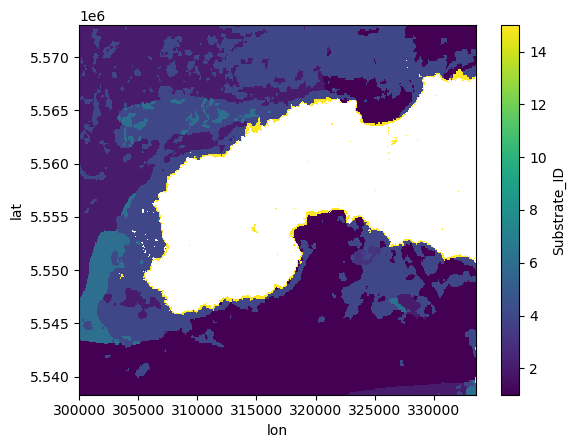

In [201]:
c2rcc_ds.Substrate_ID.where(c2rcc_ds.rrs_B2 > 0).plot(x="lon", y="lat")

In [129]:
with rasterio.open(substrate_fp) as src:
    # Sample the raster at the lat/lon points
    samples = src.sample(zip(lon_1d, lat_1d))

    # Convert the generator to a NumPy array
    substrate_values = np.array(list(samples)).flatten()

KeyboardInterrupt: 

In [ ]:
# Reshape the sampled values back to the 2D shape of lat_2d and lon_2d
substrate_2d = substrate_values.reshape(lat_2d.shape)

In [ ]:
rst_fp = os.path.join(substrate_dir, f"{poly_id}-raster.tif")

In [ ]:
gdf = gpd.read_file(substrate_fp)
gdf.crs = CRS.from_epsg(4326)
# gdf = gdf.to_crs(epsg=32630)

In [ ]:
gdf.plot()

In [ ]:
# c2rcc_ds.rio.write_crs("EPSG:4326", inplace=True)

In [ ]:
lat = c2rcc_ds.coords["lat"].values
lon = c2rcc_ds.coords["lon"].values

In [ ]:
res_x = (lon_max - lon_min) / nx
res_y = (lat_max - lat_min) / ny

In [ ]:
# transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32630', always_xy=True)

In [ ]:
# lon_min_s2, lat_max_s2 = transformer.transform(lon_min, lat_max)

In [ ]:
transform = from_bounds(lon_min, lat_min, lon_max, lat_max, nx_reg, ny)

In [ ]:
transform

In [ ]:
with open('substrate_numeric.txt', 'r') as fp:
    substrate_mapping = json.load(fp)

In [ ]:
gdf['Substrate_ID'] = gdf['Substrate'].map(substrate_mapping).astype(int)

Also apply numerical mapping to our point dataframe.

In [ ]:
ds['Substrate_ID'] = ds['Substrate'].map(substrate_mapping).astype(int)

In [ ]:
gdf.geometry.geom_type.value_counts()

In [ ]:
# def convert_multi_to_single(geom):
#     if isinstance(geom, MultiPolygon):
#         return max(geom.geoms, key=lambda p: p.area)  # Keep the largest polygon
#     return geom

In [ ]:
# gdf["geometry"] = gdf["geometry"].apply(convert_multi_to_single)

In [ ]:
gdf.is_valid.value_counts()

In [ ]:
gdf["geometry"] = gdf["geometry"].buffer(0)

In [ ]:
raster = rasterize(
    [(geom, value) for geom, value in zip(gdf.geometry.values, gdf['Substrate_ID'])],
    out_shape=(ny_reg, nx_reg),
    transform=transform,
    all_touched=True,
    fill=0,  # Background value
    dtype="uint8"
)

In [ ]:
plt.imshow(raster)

In [ ]:
lon_reg = np.linspace(lon_min, lon_max, nx_reg)
lat_reg = np.linspace(lat_min, lat_max, ny_reg)

In [ ]:
temp_da = xr.DataArray(
    raster,
    dims=('y', 'x'),
    coords={'lon': (['x'], lon_reg), 'lat': (['y'], lat_reg)}
)

In [ ]:
substrate_band = temp_da.interp(
    x=c2rcc_ds.lon,
    y=c2rcc_ds.lat,
    method="nearest"  # Use "nearest" for categorical data like Substrate_ID
)

In [ ]:
substrate_band

In [ ]:
substrate_band = substrate_band.rename({'x': 'lon', 'y': 'lat'})

In [ ]:
# substrate_band = xr.DataArray(
#     raster,
#     dims=('y', 'x'),
#     coords={'lon': c2rcc_ds.lon, 'lat': c2rcc_ds.lat},
#     name='Substrate_ID'
# )

In [ ]:
c2rcc_ds['Substrate_ID'] = substrate_band

In [ ]:
c2rcc_ds.Substrate_ID.where(c2rcc_ds.rrs_B2 > 0).plot(x="lon", y="lat")

In [ ]:
c2rcc_ds.coords

## Train model

In [ ]:
label_encoder = LabelEncoder()
ds['HabType'] = label_encoder.fit_transform(ds['HabType'])  # Store class mappings for later

In [ ]:
X = ds[['Substrate_ID', 'rrs_B2', 'rrs_B3', 'rrs_B4']]
y = ds['HabType']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
# class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)

In [ ]:
accuracy

In [ ]:
conf_matrix

In [ ]:
label_encoder.classes_

## Results

In [ ]:
c2rcc_ds.sizes

In [ ]:
test = c2rcc_ds['rrs_B2'].values.ravel()

In [ ]:
def xarray_pred(dataset, model, bands):
    shape = (dataset.sizes['y'], dataset.sizes['x'])
    data = {band: dataset[band].values.ravel() for band in bands}
    df = pd.DataFrame(data)
    pred = model.predict(df)
    pred_array = xr.DataArray(
        pred.reshape(shape),
        dims=('y', 'x'),
        coords={'lon': dataset.lon, 'lat': dataset.lat},
        name='pred'
    )
    return pred_array

In [ ]:
pred = xarray_pred(c2rcc_ds, clf, ['Substrate_ID', 'rrs_B2', 'rrs_B3', 'rrs_B4'])

In [ ]:
pred_masked = pred.where(c2rcc_ds['rrs_B2'] > 0)

In [ ]:
pred_masked.plot(x='lon', y='lat')
plt.savefig('habitat_map_test')

In [ ]:
stats.mode(pred.data.flatten())

In [ ]:
label_encoder.classes_[2]

In [ ]:
label_encoder.classes_[3]

In [ ]:
label_encoder.classes_